# Discussing Classification Metrics - nuances with multiclass 

- **Revisiting model** evaluation metrics from Machine Learning perspective


- **The nuances** Separating Binary classification and Multiclass classification


- **Our perspective** on the problem we are trying to solve and our targets


- **Clarifications** we need

## 1. Revisiting model evaluation metrics from Machine Learning perspective
 
   
Assuming Pions as our class of importance and rest as noise



**Standalone metrics**

- **Precision**: How many selected items are relevant? OR
    
    _How many particles identified by the model as pions are actually pions?_


- **Recall**: How many relevant items are selected? OR
  
  _How many pions actually present were successfully identified as pions by the model?_


**Metrics based on some combination of standalone metrics**

- **ROC-AUC Curve**: Balancing between True positive rate (pions detected as pions) and False positive rate (noise detected as pions); Ideal for class imbalance, higher the AUC or closer the model is to top left corner, the better it is.



- **PR Curve**: Balancing between Precision and Recall



- **F1 Score**: A metric that considers both Precision and recall (harmonic mean); Simple metric to balance precision and recall, higher the F1 score, better is the classifier in terms of balance.

## The class imbalance we are dealing with here
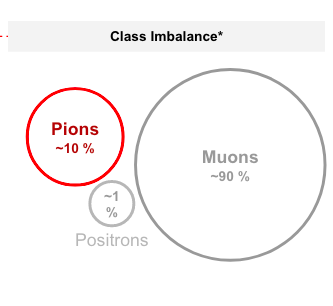

## 2. The nuances Separating Binary classification and Multiclass classification

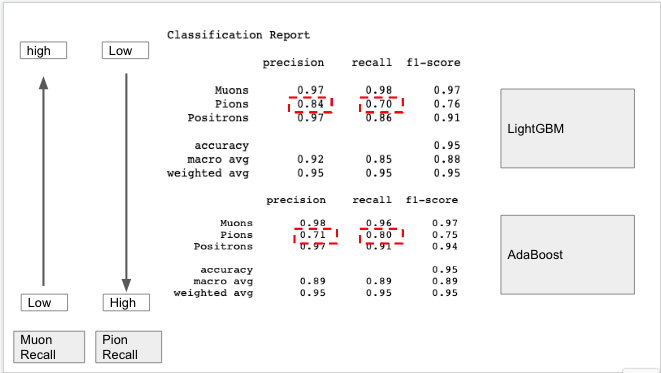

## Our perspective on the problem we are trying to solve and our targets

- Sources:
    - TRIUMF Proposal for MDS Capstone project
    - Presentation by TRIUMF dt 23 May 2022 and subsequent Discussions

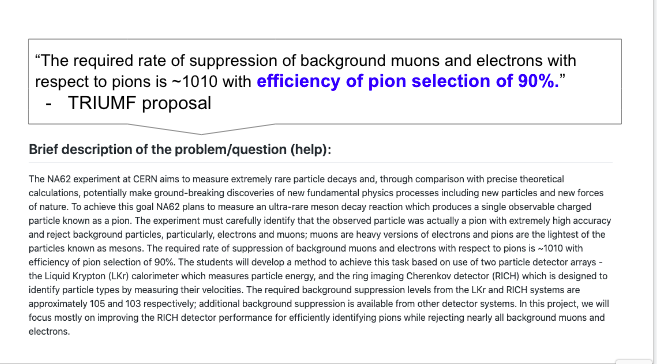

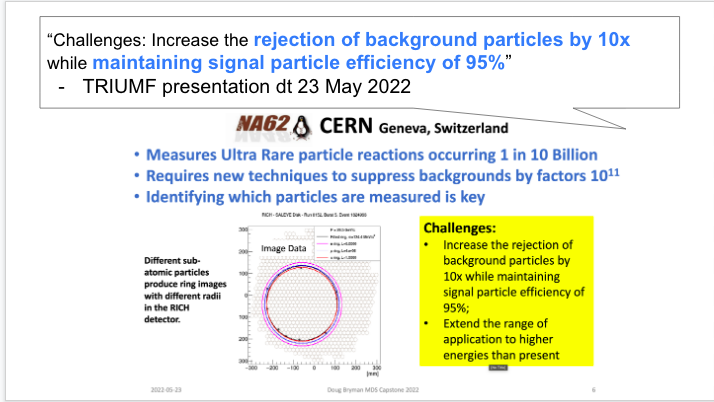

### Summary

- Pion Selection Efficiency: 90 %


- Rejection of background particles by 10x:
 
    - **Current status**: Based on Maximum Likelihood Estimation (analytical method), **1 % Muons being missclassified as pions**.    
   
    - **Our target** : Reducing **Muon missclassification** as pions by 10x from **1% to 0.1 %**

## Clarifications we need

Objective: Metrics to evaluate and tune the models, as well as quantify success of this capstone project

Alternatives for TRIUMF to provide (we can have a range - optimistic/ conservative): 
- Only pion identification as target (binary classification): Precision & Recall targets, OR f1 score OR ROC-AUC just for Pions, treating other two as noise 

- Multiclass classification (classifying all 3 particles): Precision & Recall targets, OR f1 score OR ROC-AUC individually for all 3 particles.

- Other alternatives or suggestions from TRIUMF

# Training model with Gradient Boosted Trees (LightGBM)

## Workflow:
 - Loading Data
 - Data cleaning
 - Dataset preparation and selected features
 - Gradient Boosted Trees: preliminary analysis with LightGBM, XGBoost and AdaBoost 
     - model parameters
     - Results on Sub-sampled data

 - To do:
     - Sensitivity analysis with momentum bins
     - Scaling and optimisation with full load
     - Modularization

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import h5py 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from collections import defaultdict

In [2]:
def read_RICHAI_data(file_paths):
    """Read in all the 2018 RICHAI data
    
    Parameters
    ----------
    file_paths : list of str
        List of file paths of all data sets.
        
    Returns
    -------
    data_files : dict
        Dictionary of HFD data sets     
    """
    data_files = {}
    for file_path in file_paths:
        name = file_path.split("/")[4] + "/" + file_path.split("/")[5].split(".")[0]
        data_files[name] = h5py.File(file_path)
    
    return data_files

In [3]:
def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas
    
    Parameters
    ----------
    dfile : HDF5 file
        The RICHAI HDF5 file to convert to pandas.
        
    Returns
    -------
    df : pd.DataFrame
        pandas DataFrame with Events data
    """
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    
    df["label"] = labels
    
    # hit mapping values
    df["first_hit"] = np.array(dfile["HitMapping"])[:-1]  # hit n
    df["last_hit"] = np.array(dfile["HitMapping"])[1:]    # hit n + 1
    df["total_hits"] = df["last_hit"] - df["first_hit"]
    
    return df

In [5]:
def get_string_label(label):
    """Add string label to pandas df (to be used with map)"""
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    elif label == 2:
        return "positron"

In [4]:
def compute_seq_id(hit, or_id=0):
    """Compute the RICH PMT sequence ID"""
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id, otypes=[int])

In [5]:
def get_hit_info_df(f, df, event):
    """Get the hit info for an event in a pandas dataframe
    
    Parameters
    ----------
    f : HDF5 file
        The RICHAI HDF5 file.
    df : pandas DataFrame
        A pandas DataFrame representation of the HDF5 Events file.
    event : int
        The event number to get the hit info for.
        
    Returns
    -------
    positions : pd.DataFrame
        pandas DataFrame with hits data for a given event
    """
    positions = []
    
    # get our hit data for this event
    idx_from = df.loc[event]["first_hit"]
    idx_to = df.loc[event]["last_hit"]
    hit_data = f["Hits"][idx_from:idx_to]
    
    # get our pm locations for this event
    for hit in hit_data:
        pm_idx = compute_seq_id(hit)
        positions.append(position_map[pm_idx])
    
    # add hit time, chod time, and delta
    positions = pd.DataFrame(positions, columns=["x", "y", "mirror"])
    positions["hit_time"] = hit_data["hit_time"]
    positions["chod_time"] = df["chod_time"][event]
    positions["chod_delta"] = positions["hit_time"] - positions["chod_time"]
    positions["class"] = df["class"][event]
    positions["event"] = event
    
    return positions

In [6]:
def draw_pmt_pos(ax,pmt_pos):
    """
        Add circle patches corresponding to the PMT position to the Axes object ax
    """
    for i in pmt_pos:
        if i[2] == 0: # 0: Jura / 1: Salève, PMT disks are identical, we can pick either one. [TODO: CHECK!]
            ax.add_patch(plt.Circle((i[0],i[1]),1.0, color='black'))
    return ax

In [7]:
def get_class_samples(df, n, seed, momentum_bin=None):
    """Sample n samples for each particle class from the events dataframe"""
    
    if momentum_bin is not None:
        df = df.query("momentum_bin == @momentum_bin")
        
    samples = pd.concat(
        [
            df[df["class"] == "muon"].sample(n=n, random_state=seed),
            df[df["class"] == "pion"].sample(n=n, random_state=seed),
            df[df["class"] == "positron"].sample(n=n, random_state=seed)        
        ]

    )
    
    return samples

In [10]:
# file_paths = glob.glob("/data/bvelghe/capstone2022/*/*")
# data_files = read_RICHAI_data(file_paths)
# data_files.keys()

dict_keys(['A/Run008563', 'A/Run008548', 'A/Run008564', 'A/Run008553', 'A/Run008562', 'C/2018E', 'B/2018B'])

In [9]:
# f = data_files["A/Run008563"]
f = h5py.File("../Run008594.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01_patched.h5")
# f.keys()

In [12]:
# position_map = np.load("../tools/rich_pmt_positions.npy")
# position_map.shape

(1952, 3)

In [10]:
df = events_to_pandas(f)

# add class label (text)
df["class"] = df["label"]
# .apply(get_string_label)

# add momentum bin
momentum_bins = ['0-9', '10-19', '20-29', '30-39','40+']
df["momentum_bin"] = pd.cut(
    df["track_momentum"],
    [0, 10, 20, 30, 40, np.inf],
    labels=momentum_bins
)

df.shape

(172353, 18)

## Raw Data and cleaning

In [11]:
df

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,first_hit,last_hit,total_hits,class,momentum_bin
0,8594,1500,51835,0,44.524044,18.484293,187.200104,-58.681900,-86.871895,7.027871e-02,1.000000e+00,0.141723,0,0,20,20,0,40+
1,8594,1500,61335,1,58.924713,3.847185,192.066986,-0.824893,19.171865,2.037298e-01,6.879443e-01,1.000000,0,20,76,56,0,40+
2,8594,1500,120076,0,43.830074,5.751905,182.237549,5.661263,-2.242294,1.000000e+00,5.518036e-01,0.001307,0,76,114,38,0,40+
3,8594,1500,159774,1,47.209805,8.041667,188.249054,-45.440781,75.533646,8.779179e-03,3.511907e-01,1.000000,0,114,144,30,0,40+
4,8594,1500,162112,0,62.517815,5.636743,187.449661,-41.332932,41.035915,3.496890e-02,2.521802e-01,1.000000,0,144,172,28,0,40+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172348,8594,9,1179549,0,20.889257,25.301548,189.336273,-280.969452,59.472492,1.216099e-37,1.216099e-37,1.000000,2,6453076,6453103,27,2,20-29
172349,8594,10,48116,0,19.988508,5.186560,193.138199,-332.259003,41.599567,1.216099e-37,2.167693e-27,1.000000,2,6453103,6453144,41,2,10-19
172350,8594,10,2153067,1,31.388176,26.368130,191.698593,-182.408600,69.812134,3.499012e-28,4.526704e-10,1.000000,2,6453144,6453184,40,2,30-39
172351,8594,11,1299208,0,33.643093,6.939435,190.658127,-51.991673,58.232002,6.634031e-14,1.432839e-04,1.000000,2,6453184,6453210,26,2,30-39


In [12]:
df.describe().loc[['min', 'max', 'std', 'count'],'track_momentum':]

,track_momentum,chod_time,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,first_hit,last_hit,total_hits,class
min,5.805404,-24.221193,0.000000,-492.119568,-217.719467,1.216099e-37,1.216099e-37,1.216099e-37,0.00000,0.000000e+00,2.000000e+01,6.000000,0.00000
max,73.757187,41.355415,999999.000000,999999.000000,999999.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.00000,6.453210e+06,6.453278e+06,304.000000,2.00000
std,12.889791,8.265625,42022.410156,83262.054688,83254.132812,3.923231e-01,3.488064e-01,3.198474e-01,0.35001,1.851026e+06,1.851026e+06,21.058805,0.35001
count,172353.000000,172353.000000,172351.000000,172351.000000,172351.000000,1.723530e+05,1.723530e+05,1.723530e+05,172353.00000,1.723530e+05,1.723530e+05,172353.000000,172353.00000


In [13]:
std_raw = df.describe().std()['track_momentum':]
std_raw

track_momentum              6.092369e+04
chod_time                   6.093188e+04
ring_radius                 3.477223e+05
ring_centre_pos_x           3.459322e+05
ring_centre_pos_y           3.458913e+05
ring_likelihood_pion        6.093587e+04
ring_likelihood_muon        6.093574e+04
ring_likelihood_positron    6.093591e+04
label                       6.093586e+04
first_hit                   2.224801e+06
last_hit                    2.224819e+06
total_hits                  6.091230e+04
class                       6.093586e+04
dtype: float64

In [14]:
# Preparing Input data for GBT
def preprocessor(df):
    """Clean data for initial model training and analysis"""
    
    # Ring radius - cleaning for anomalous values
    df_clean = df[(df["ring_radius"]<300) & (df["ring_radius"]>0)]
    
    # Total hits - removing 0 hits and anomalous values (very high hits corresponded to positrons)
    df_clean = df_clean[(df_clean["total_hits"]>0) & (df_clean["total_hits"]<1000)]
    
    # ring_center_pos_X - Cleaning for anomalies
    df_clean = df_clean[df_clean['ring_centre_pos_x']<1000]
    
    # ring_center_pos_Y - Cleaning for anomalies
    df_clean = df_clean[df_clean['ring_centre_pos_y']<1000]
    
    return df_clean

In [15]:
df_clean = preprocessor(df)
print(f"Observations removed by preprocessor: {(df.shape[0]-df_clean.shape[0])} ({(df.shape[0]-df_clean.shape[0]) / df.shape[0] * 100:.2f} %)")
df.describe().loc[['min', 'max', 'std', 'count'],'track_momentum':]

Observations removed by preprocessor: 1212 (0.70 %)


,track_momentum,chod_time,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,first_hit,last_hit,total_hits,class
min,5.805404,-24.221193,0.000000,-492.119568,-217.719467,1.216099e-37,1.216099e-37,1.216099e-37,0.00000,0.000000e+00,2.000000e+01,6.000000,0.00000
max,73.757187,41.355415,999999.000000,999999.000000,999999.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.00000,6.453210e+06,6.453278e+06,304.000000,2.00000
std,12.889791,8.265625,42022.410156,83262.054688,83254.132812,3.923231e-01,3.488064e-01,3.198474e-01,0.35001,1.851026e+06,1.851026e+06,21.058805,0.35001
count,172353.000000,172353.000000,172351.000000,172351.000000,172351.000000,1.723530e+05,1.723530e+05,1.723530e+05,172353.00000,1.723530e+05,1.723530e+05,172353.000000,172353.00000


## Training LightGBM

In [16]:
df_clean.columns

Index(['run_id', 'burst_id', 'event_id', 'track_id', 'track_momentum',
       'chod_time', 'ring_radius', 'ring_centre_pos_x', 'ring_centre_pos_y',
       'ring_likelihood_pion', 'ring_likelihood_muon',
       'ring_likelihood_positron', 'label', 'first_hit', 'last_hit',
       'total_hits', 'class', 'momentum_bin'],
      dtype='object')

### Subsampled df for trial run

In [17]:

df_clean_light = df_clean.sample(frac=0.1, replace=False, random_state=123)
df_clean_light.label.value_counts()

0    15292
1     1671
2      151
Name: label, dtype: int64

### Features

In [18]:
# Selecting X & y
X = df_clean_light.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits'
]]

y = df_clean_light.loc[:,'class']

In [19]:
# Training and validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y, 
    test_size=0.25
)

### Examining the stratified sub-sample

In [20]:
# Testing for stratification  - training set
y_train.value_counts()

0    11469
1     1253
2      113
Name: class, dtype: int64

In [21]:
# Testing for stratification - validation set
y_test.value_counts()

0    3823
1     418
2      38
Name: class, dtype: int64

## Baseline lightGBM classifier results

In [22]:
model = lgb.LGBMClassifier(random_state=123)
model.fit(X_train, y_train)

LGBMClassifier(random_state=123)

In [23]:
y_pred = model.predict(X_test)

In [24]:
print('\nClassification Report\n')
print(classification_report(
    y_test, y_pred, 
    target_names=['Muons', 'Pions', 'Positrons']
    )
)


Classification Report

              precision    recall  f1-score   support

       Muons       0.97      0.98      0.97      3823
       Pions       0.82      0.69      0.75       418
   Positrons       0.85      0.92      0.89        38

    accuracy                           0.95      4279
   macro avg       0.88      0.86      0.87      4279
weighted avg       0.95      0.95      0.95      4279



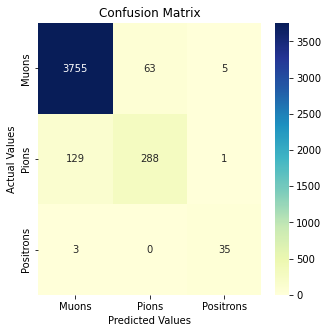

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Muons', 'Pions', 'Positrons'], 
                     columns = ['Muons', 'Pions', 'Positrons'])
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Tuning lightGBM multiclass classifier

In [26]:
# Taking inverse weights of classes
n_muon = df_clean_light.query("label == 0").shape[0]
n_pion = df_clean_light.query("label == 1").shape[0]
n_positron = df_clean_light.query("label == 2").shape[0]
n_total = df_clean_light.shape[0]

class_weight = {
    0 : 1 - n_muon/n_total,
    1 : 1 - n_pion/n_total,
    2 : 1 - n_positron/n_total
}

class_weight

{0: 0.10646254528456234, 1: 0.9023606404113591, 2: 0.9911768143040786}

In [27]:
model = None
model = lgb.LGBMClassifier(
#         boosting_type='goss',
#         num_leaves=10,
#         max_depth = 10,
        learning_rate = 0.3,
#         n_estimators = 100, 
        class_weight= class_weight,
#         objective='multiclass',
#         num_class = 3,
        random_state=123,)
model.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 0.10646254528456234, 1: 0.9023606404113591,
                             2: 0.9911768143040786},
               learning_rate=0.3, random_state=123)

In [28]:
y_pred = model.predict(X_test)

In [29]:
print('\nClassification Report\n')
print(classification_report(
    y_test, y_pred, 
    target_names=['Muons', 'Pions', 'Positrons']
    )
)


Classification Report

              precision    recall  f1-score   support

       Muons       0.97      0.96      0.97      3823
       Pions       0.68      0.75      0.71       418
   Positrons       0.86      0.95      0.90        38

    accuracy                           0.94      4279
   macro avg       0.84      0.88      0.86      4279
weighted avg       0.94      0.94      0.94      4279



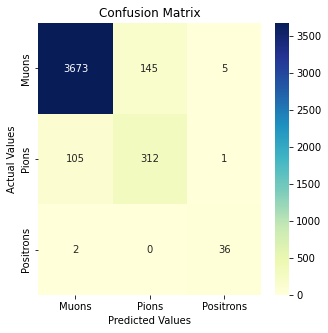

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Muons', 'Pions', 'Positrons'], 
                     columns = ['Muons', 'Pions', 'Positrons'])
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Baseline XGBoost Classifier

In [31]:
xgb_cl = XGBClassifier(random_state =123)
xgb_cl.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:53:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [32]:
y_pred = model.predict(X_test)

In [33]:
print('\nClassification Report\n')
print(classification_report(
    y_test, y_pred, 
    target_names=['Muons', 'Pions', 'Positrons']
    )
)


Classification Report

              precision    recall  f1-score   support

       Muons       0.97      0.96      0.97      3823
       Pions       0.68      0.75      0.71       418
   Positrons       0.86      0.95      0.90        38

    accuracy                           0.94      4279
   macro avg       0.84      0.88      0.86      4279
weighted avg       0.94      0.94      0.94      4279



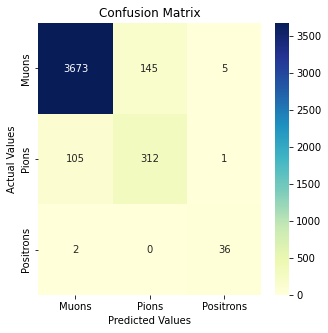

In [34]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Muons', 'Pions', 'Positrons'], 
                     columns = ['Muons', 'Pions', 'Positrons'])
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## AdaBoost Classifier baseline model

In [35]:
abc = AdaBoostClassifier(n_estimators=100, random_state=123)
abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [36]:
print('\nClassification Report\n')
print(classification_report(
    y_test, y_pred, 
    target_names=['Muons', 'Pions', 'Positrons']
    )
)


Classification Report

              precision    recall  f1-score   support

       Muons       0.97      0.96      0.97      3823
       Pions       0.68      0.75      0.71       418
   Positrons       0.86      0.95      0.90        38

    accuracy                           0.94      4279
   macro avg       0.84      0.88      0.86      4279
weighted avg       0.94      0.94      0.94      4279



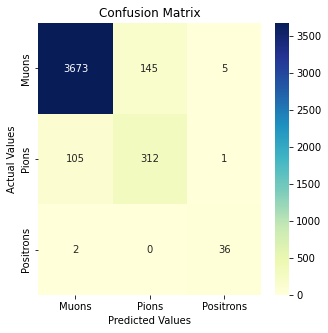

In [37]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Muons', 'Pions', 'Positrons'], 
                     columns = ['Muons', 'Pions', 'Positrons'])
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()